# PGM Experiment - Pfam database - On Kmeans and PCA

## Introduction

In this project, we aim to use data from the [Pfam database](https://www.kaggle.com/datasets/googleai/pfam-seed-random-split), which includes amino acid sequences of a protein annotated by a family. The goal is to construct a protein family classification model to make predictions for sequences for which we do not have a label.

__Content :__
* Dataset Analysis
* Unsupervised method : Kmeans
* Supervised method : Perceptron
* Result analysis

In [ ]:
!pip install torchsummary

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.utils import class_weight
from torchsummary import summary
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

import plotly.express as px
import umap

import seaborn as sns
from sklearn.metrics import confusion_matrix

## Homemade code from utils

from utils import *

C:\Users\pierr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset analysis

Before we can start building the model, it's essential to understand the dataset's data structure. The labels are given by `family_id`. We'll use the sequences as input, not the `aligned_sequences`. This is because if we encounter a new protein, we won't have its sequence alignment to a family, primarily since we won't know its family. Thus, after examining `data splitting`, `label coverage`, and `label distribution`, we'll delve into preprocessing these amino acid sequences. To do this, we will look at:

* The distribution of `sequence lengths`
* The distribution of `amino acids`

Following this, we'll identify any anomalies, outliers, or instances of `imbalanced data`. Based on these insights, we'll then be in a position to choose the most appropriate model.

### Data Loading

In [ ]:
def read_files(data_dirpath, partition):
    dirpath = os.path.join(data_dirpath, partition)
    if not os.path.exists(dirpath):
        raise ValueError(f"Directory {dirpath} does not exist.")
    file_names = os.listdir(dirpath)
    csv_files = []

    for fn in file_names:
        with open(os.path.join(dirpath, fn), "r") as f:
            csv_files.append(pd.read_csv(f, index_col=None))

    return pd.concat(csv_files, ignore_index=True)


def load_data(data_dirpath):
    df_test = read_files(data_dirpath, "test")

    df_train = read_files(data_dirpath, "train")

    df_test.drop_duplicates(subset="sequence", inplace=True)

    df_train.drop_duplicates(subset="sequence", inplace=True)

    return df_train, df_test


df_train, df_test = load_data(
    data_dirpath=r"C:\Users\pierr\Desktop\pgm_dataset\random_split"
)

In [ ]:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [ ]:
train_split_ratio = np.round((len(df_train) / (len(df_train) + len(df_test))) * 100, 2)
test_split_ratio = np.round((len(df_test) / (len(df_train) + len(df_test))) * 100, 2)

pd.DataFrame(
    {
        "split": ["train", "test"],
        "percentage of all data": [
            train_split_ratio,
            test_split_ratio,
        ],
        "nbr of sequences": [len(df_train), len(df_test)],
    }
)

,split,percentage of all data,nbr of sequences
0,train,89.59,1086315
1,test,10.41,126161


The distribution of data among the different sets is good. Now we need to ensure that `train` covers all the labels of `dev` and `test`, otherwise we will need to add a threshold to our model for unknown label.

In [ ]:
print(len(np.unique(df_train["family_accession"])))

17929


In [ ]:
pd.DataFrame(
    {
        "split": ["test"],
        "training set coverage": [
            np.isin(
                np.unique(df_test["family_accession"]),
                np.unique(df_train["family_accession"]),
            ).sum()
            / len(np.unique(df_test["family_accession"])),
        ],
    }
)

,split,training set coverage
0,test,1.0


There is a total recovery of the label.

### Label distribution

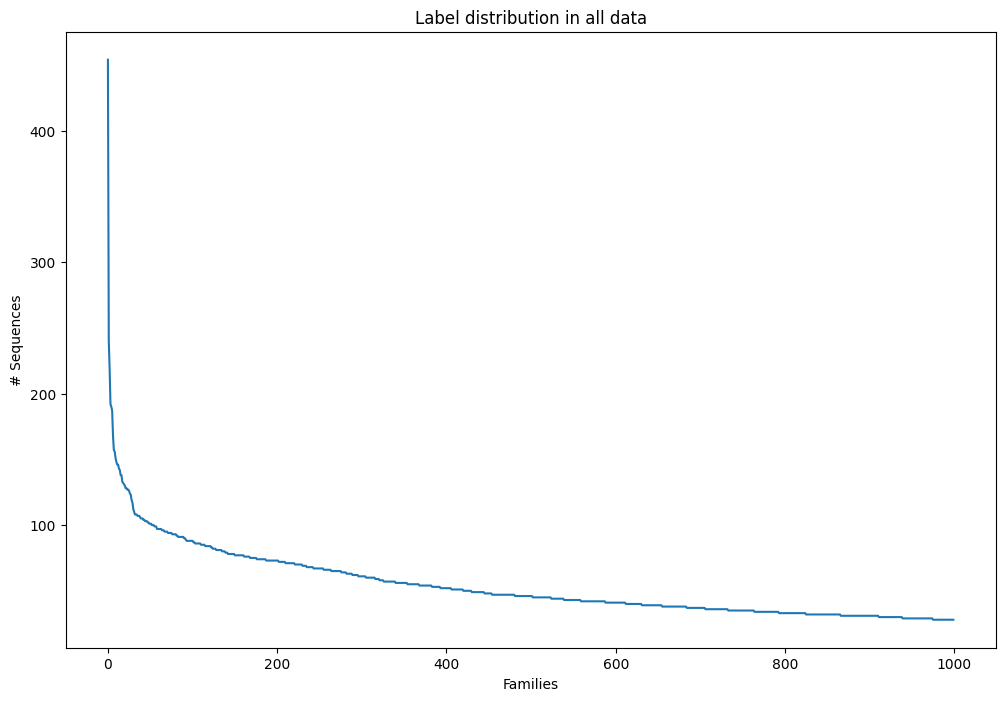

In [ ]:
def plot_family_size_distribution(data, nbr_fam=1000):
    family_id_counts = data["family_id"].value_counts().reset_index()
    family_id_counts.columns = ["families", "count"]
    family_id_counts = family_id_counts.sort_values(
        by="count", ascending=False
    ).reset_index(drop=True)
    family_id_counts = family_id_counts[:min(nbr_fam, len(family_id_counts))]
    plt.figure(figsize=(12, 8))
    plt.plot(family_id_counts.index, family_id_counts["count"])
    plt.title("Label distribution in all data")
    plt.ylabel("# Sequences")
    plt.xlabel("Families")
    plt.show()


plot_family_size_distribution(df_test, nbr_fam=1000)

In [ ]:
print("Number of unique families in the data: ", len(np.unique(df_test["family_id"])))

Number of unique families in the data:  13071


In [ ]:
family_id_counts = df_test["family_id"].value_counts().reset_index()
family_id_counts.columns = ["families", "count"]
family_id_counts = family_id_counts.sort_values(
    by="count", ascending=False
).reset_index(drop=True)

print(family_id_counts.loc[0])
print(family_id_counts.loc[100])
print(family_id_counts.loc[50])

families    Methyltransf_25
count                   454
Name: 0, dtype: object
families    C8
count       88
Name: 100, dtype: object
families    FMN_bind
count            101
Name: 50, dtype: object


Results above indicate that our dataset is quite imbalanced, and imbalance is significant. Note that the most frequent label has 4545 seqs while 100th most frequent has only 878 and there are 17929 families.

For reasons of computational resources and time, I will work on a classification model on the top 10 classes for Kmeans experiment and supervised method comparison.

In [ ]:
# Get the 50th largest family_id

FAMILIES = 10

top_families = df_test["family_id"].value_counts().nlargest(FAMILIES).index.tolist()



# Filter the dataset to keep only the top 50 families



df_train = df_train[df_train["family_id"].isin(top_families)].reset_index(drop=True)



df_test = df_test[df_test["family_id"].isin(top_families)].reset_index(drop=True)



# Add a column named "label" which is unique index for every label


label_to_index = {
    label: index for index, label in enumerate(df_test["family_id"].unique())
}

index_to_label = {value: key for key, value in label_to_index.items()}

df_train["label"] = df_train["family_id"].apply(lambda x: label_to_index[x])


df_test["label"] = df_test["family_id"].apply(lambda x: label_to_index[x])



train_split_ratio = np.round((len(df_train) / (len(df_train) + len(df_test))) * 100, 2)

test_split_ratio = np.round((len(df_test) / (len(df_train) + len(df_test))) * 100, 2)



pd.DataFrame(
    {
        "split": ["train", "test"],
        "percentage of all data": [
            train_split_ratio,
            test_split_ratio,
        ],
        "nbr of sequences": [len(df_train), len(df_test)],
    }
)

,split,percentage of all data,nbr of sequences
0,train,88.92,16966
1,test,11.08,2114


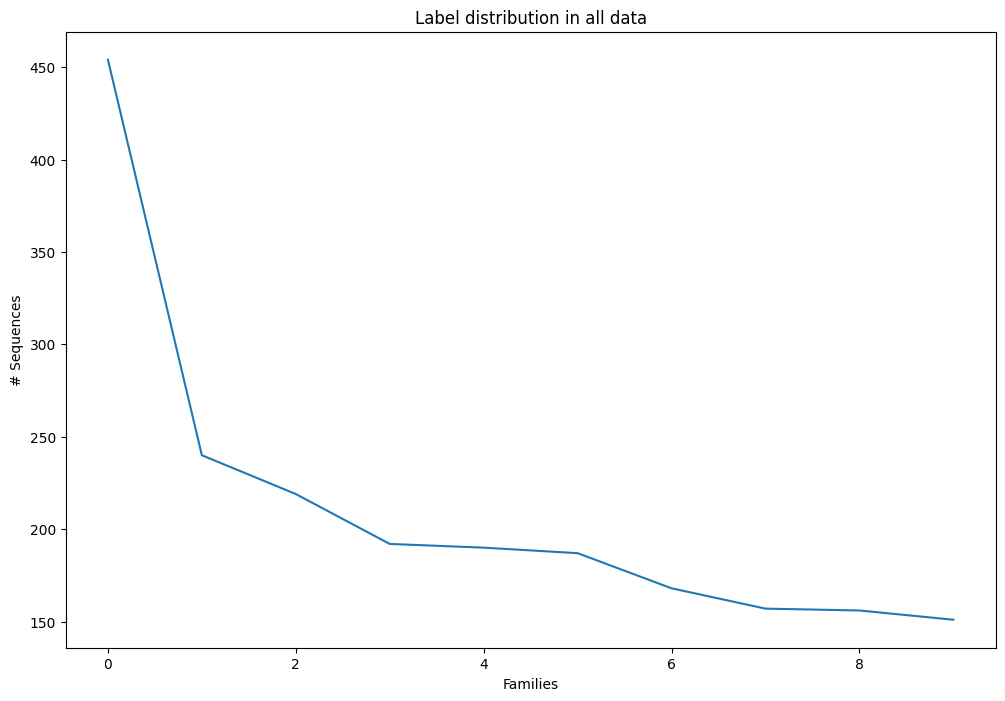

In [ ]:
plot_family_size_distribution(df_test, nbr_fam=FAMILIES)

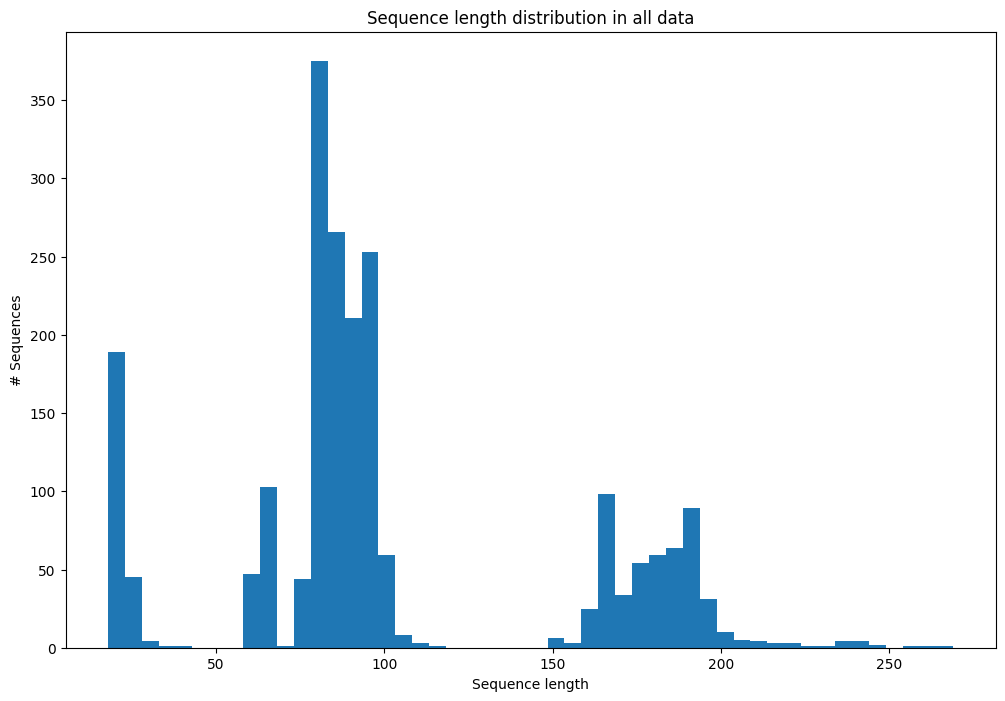

In [ ]:
def plot_sequence_size_distribution(data):
    sequence_lengths = data["sequence"].str.len()

    plt.figure(figsize=(12, 8))
    plt.hist(sequence_lengths, bins=50)
    plt.title("Sequence length distribution in all data")
    plt.ylabel("# Sequences")
    plt.xlabel("Sequence length")
    plt.show()


plot_sequence_size_distribution(df_test)

The sequence length distribution is quite variable with most of the sequences length in range 50-250.

Thus, to reduce computational complexity, we will truncate and pad sequences to length of 250 for the supervised part.

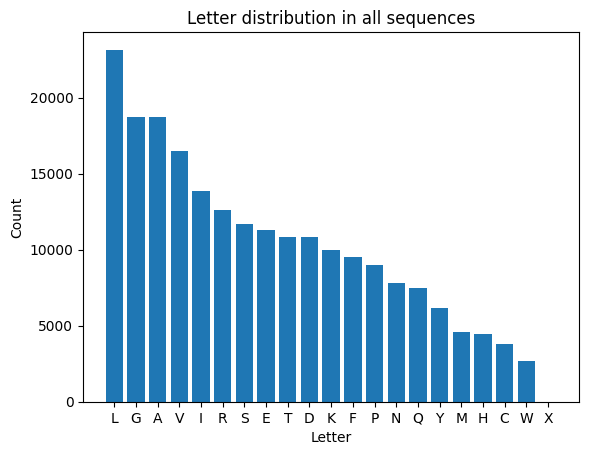

21


In [ ]:
aa_counts = Counter("".join(df_test["sequence"]))
aa_df = pd.DataFrame({"aa": list(aa_counts.keys()), "freq": list(aa_counts.values())})
aa_df = aa_df.sort_values("freq", ascending=False).reset_index()[["aa", "freq"]]

plt.bar(aa_df["aa"], aa_df["freq"])
plt.title("Letter distribution in all sequences")
plt.xlabel("Letter")
plt.ylabel("Count")
plt.show()
print(len(aa_df["aa"].unique()))

### Unsupervised experimentations on Kmeans

In [ ]:
# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(
    analyzer="char", ngram_range=(1, 2), use_idf=False, smooth_idf=True, norm=None
)

# Fit the vectorizer on X_train
vectorizer.fit(df_test["sequence"].tolist())

# Transform X_train using the fitted vectorizer
X = vectorizer.transform(df_test["sequence"].tolist())
X_mean = np.mean(X, axis=0)
X_mean = X_mean.repeat(X.shape[0], axis=0)
X = X - X_mean
X = np.asarray(X)
Y = df_test["label"].tolist()
# Print the shapes of the train and test sets
print("set shape:", X.shape)

set shape: (2114, 424)


In [ ]:
# Define the number of components
n_components = FAMILIES - 1

# Create an instance of PCA
pca = PCA(n_components=n_components)

# Fit the PCA on X_train_tfidf
X_pca = pca.fit_transform(X)

# Sort X based on the first column

sorted_indices = np.argsort(X_pca[:, 0])[::-1]

X_pca = X_pca[sorted_indices]
Y = np.array(Y)
sorted_Y = Y[sorted_indices]

In [ ]:
# Create a UMAP object with 3 dimensions
umap_3d = umap.UMAP(n_components=3)

# Fit the UMAP model to your data
umap_3d.fit(X_pca)

# Transform your data to the 3D UMAP representation
umap_data_3d = umap_3d.transform(X_pca)

fig = px.scatter_3d(
    x=umap_data_3d[:, 0],
    y=umap_data_3d[:, 1],
    z=umap_data_3d[:, 2],
    color=[index_to_label[i] + " [" + str(i) + "]" for i in sorted_Y],
    labels={"color": "Label"},
    title="3D UMAP plot",
)

fig.update_layout(
    scene=dict(
        xaxis=dict(
            title="UMAP 1",
            showticklabels=False,  # Hide tick labels on X axis
            ticks="",  # Hide ticks on X axis
        ),
        yaxis=dict(
            title="UMAP 2",
            showticklabels=False,  # Hide tick labels on Y axis
            ticks="",  # Hide ticks on Y axis
        ),
        zaxis=dict(
            title="UMAP 3",
            showticklabels=False,  # Hide tick labels on Z axis
            ticks="",  # Hide ticks on Z axis
        ),
    )
)


fig.show()

Text(0.5, 1.0, 'K-means Confusion Matrix')

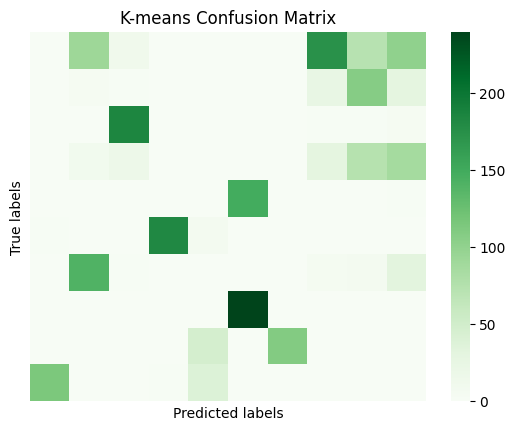

In [ ]:
# Define the number of clusters
n_clusters = FAMILIES

# Create an instance of KMeans
kmeans = KMeans(k=n_clusters, init="k-means++", max_iterations=100)

# Fit the KMeans on X_train_pca
kmeans.fit(X_pca)

# Predict the clusters for X_train_pca
train_clusters = kmeans.predict(X_pca)

cm = confusion_matrix(sorted_Y, train_clusters)

ax = plt.subplot()
sns.heatmap(cm, annot=False, ax=ax, fmt="g", cmap="Greens")
# labels, title and ticks
ax.set_xticks([])
ax.set_yticks([])

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("K-means Confusion Matrix")

0.6641438032166509


Text(0.5, 1.0, 'K-means Confusion Matrix')

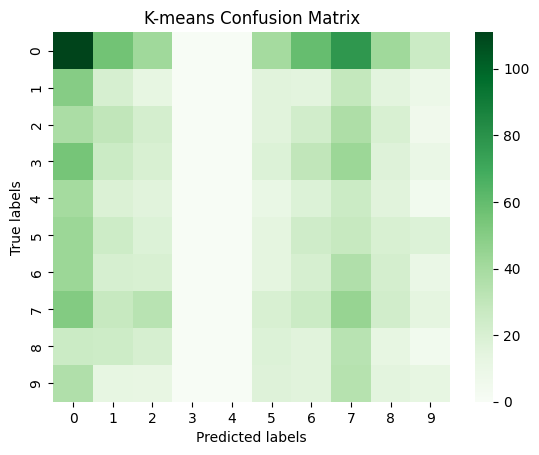

In [ ]:
cm_argmax = cm.argmax(axis=0)
y_pred_ = np.array([cm_argmax[i] for i in train_clusters])
cm_ = confusion_matrix(Y, y_pred_)
print(clustering_accuracy(sorted_Y, y_pred_))
ax = plt.subplot()
sns.heatmap(cm_, annot=False, ax=ax, fmt="g", cmap="Greens")

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("K-means Confusion Matrix")

In [ ]:
beta = 0.5

P = np.zeros((X.shape[0], X.shape[0]), dtype=np.float16)
X_pca = X_pca.astype(np.float16)
for k in range(FAMILIES - 1):
    v = X_pca[:, k]
    v = np.expand_dims(v, axis=-1)
    P_add = v @ np.transpose(v)
    P += P_add
R = P / (np.sqrt(np.diag(P))[:, np.newaxis] * np.sqrt(np.diag(P))[np.newaxis, :])
R_binary = np.where(R >= beta, 1, 0)

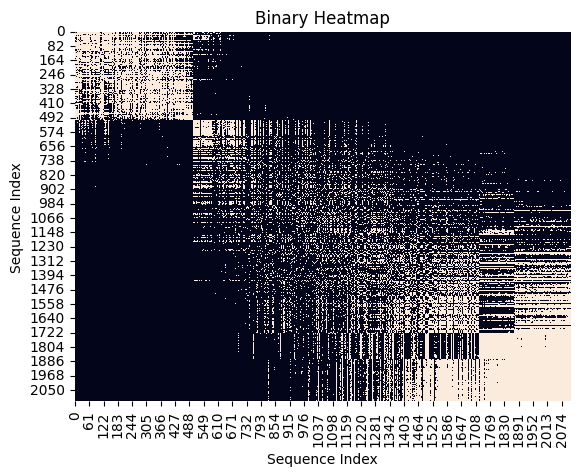

In [ ]:
# Create a binary heatmap using the P_binary array
sns.heatmap(R_binary.astype("int16"), annot=False, fmt="s", cbar=False)

# Set the title and labels
plt.title("Binary Heatmap")
plt.xlabel("Sequence Index")
plt.ylabel("Sequence Index")

# Display the plot
plt.show()

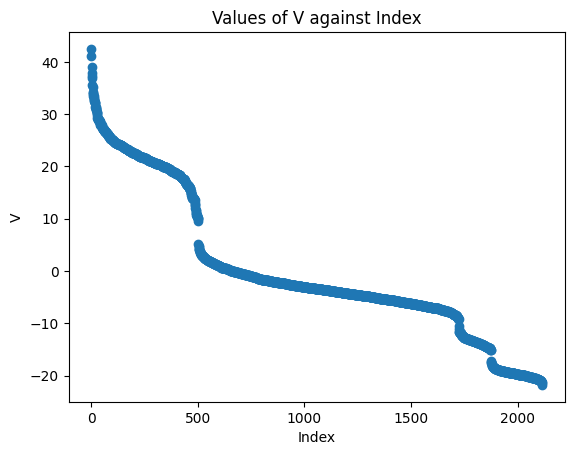

In [ ]:
# Assuming V is a list or array containing the values
index = range(len(X_pca[:, 0]))

plt.scatter(index, X_pca[:, 0])
plt.xlabel("Index")
plt.ylabel("V")
plt.title("Values of V against Index")
plt.show()

### Tokenization

We can observe that X and U are very rare so we will simply ignore them during tokenization.

In this preprocessing step we define the vocabulary for amino acids to map them to integers.
After tokenizing, truncating and padding the sequences we encode labels as one hot.

In [ ]:
# Define the vocabulary mapping amino acid letters
amino_acids = aa_df["aa"].unique()[:-2]
token2ind = {}
for idx, aa in enumerate(amino_acids):
    token2ind[aa] = idx + 1

token2ind["X"] = 0
token2ind["U"] = 0

print(token2ind)
print(len(token2ind))

{'L': 1, 'G': 2, 'A': 3, 'V': 4, 'I': 5, 'R': 6, 'S': 7, 'E': 8, 'T': 9, 'D': 10, 'K': 11, 'F': 12, 'P': 13, 'N': 14, 'Q': 15, 'Y': 16, 'M': 17, 'H': 18, 'C': 19, 'X': 0, 'U': 0}
21


In [ ]:
df_train["tokenized"] = df_train["sequence"].apply(
    lambda x: np.array([token2ind.get(aa, len(token2ind)) for aa in x])
)
df_test["tokenized"] = df_test["sequence"].apply(
    lambda x: np.array([token2ind.get(aa, len(token2ind)) for aa in x])
)

# Define the number of classes
num_classes = FAMILIES


# Define a function to one-hot encode the label
def one_hot_encode(label):
    one_hot = np.zeros(num_classes)
    one_hot[label] = 1
    return one_hot


# Add a new column 'target' to the dataframe with one-hot encoded values

df_train["target"] = df_train["label"].apply(one_hot_encode)
df_test["target"] = df_test["label"].apply(one_hot_encode)

# Truncate and pad sequences to length of 300
maxlen = 250

def pad_sequence(sequence, maxlen=maxlen):
    if len(sequence) > maxlen:
        return sequence[:maxlen]
    elif len(sequence) < maxlen:
        return np.concatenate((sequence, np.array([0] * (maxlen - len(sequence)))))
    else:
        return sequence

df_train["tokenized"] = df_train["tokenized"].apply(pad_sequence)
df_test["tokenized"] = df_test["tokenized"].apply(pad_sequence)

In [ ]:
X_train = np.stack(df_train["tokenized"].values)
X_test = np.stack(df_test["tokenized"].values)
print(X_train.shape, X_test.shape)

(16966, 250) (2114, 250)


In [ ]:
y_train = np.stack(df_train["target"].values)
y_test = np.stack(df_test["target"].values)
print(y_train.shape, y_test.shape)

(16966, 10) (2114, 10)


We have now a good preprocessed dataset.

## Method explanation

### Solving the Machine Learning Problem in Protein Classification

There are several ways to approach the machine learning problem of protein classification:

1. **Traditional Sequence Alignment Tools**:
    - One could use traditional sequence alignment tools like BLAST or HMMER to find similarities between protein sequences and known family signatures.
    - Such tools have been foundational in protein family classification for many years.
    - However, they may be computationally intensive and might miss subtle sequence variations or motifs vital for functional differentiation. [Pfam Reference](https://pubmed.ncbi.nlm.nih.gov/33125078/)

2. **Feature Extraction Techniques**:
    - Another approach is converting protein sequences into fixed-length feature vectors.
    - For example, using k-mer frequencies, where 'k' is a small number, to represent the occurrence of sub-sequences of length 'k' in the protein sequence, or a TF IDF weigthing as we have done.
    - These feature vectors can then be used with traditional machine learning algorithms like Kmeans, support vector machines (SVM), random forests, or gradient boosting machines.

3. **Deep Learning**:
    - Deep learning has also seen significant advancements in this area.
    - Recurrent neural networks (RNNs), especially long short-term memory (LSTM) networks, are apt for sequence data like protein sequences. They can identify long-range dependencies in the sequence data, potentially finding intricate patterns that classical methods might overlook.
    - Another promising deep learning architecture for this purpose is the transformer, which has shown outstanding results in natural language processing tasks and can be adapted for protein sequence classification. [Attention is All You Need](https://arxiv.org/abs/1706.03762)

For our solution, we'll employ a neural network-based approach. Owing to time and computational constraints, we'll design a simple model with an embedding layer, a hidden layer, and a classification head. If needed, we can enhance the results by incorporating Resnet and convolutional layers. [Resnet Reference](https://arxiv.org/abs/1512.03385)

We could use the transformer's implementation based on [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) and could have integrated a pretrained model like ProBert and fine-tuned it. [Reference](https://www.biorxiv.org/content/10.1101/2021.05.24.445464v1)

> Some preprocessing code in the section above was adapted from [Kaggle: Pfam Embedding](https://www.kaggle.com/code/gboduljak/pfam-embedding-is-all-you-need).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X_train, y_labels):
        self.sequences = X_train
        self.labels = y_labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return sequence, label


def get_loader(X_train, y_labels, batch_size=64):
    dataset = CustomDataset(X_train, y_labels)
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    return data_loader

In [ ]:
trainloader = get_loader(X_train, y_train)
testloader = get_loader(X_test, y_test)

In [ ]:
discretized_labels = np.argmax(y_train, axis=1)

label_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(discretized_labels), y=discretized_labels
)
label_weights = dict(enumerate(label_weights))

weights = torch.tensor(list(label_weights.values())).to(device)
weights.shape

torch.Size([10])

In [ ]:
class EmbeddingModel(nn.Module):
    def __init__(
        self, input_size, num_embedding, embedding_dim, nbr_classes, dropout=0.5
    ):
        super(EmbeddingModel, self).__init__()
        """
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         """

        self.encoder = nn.Embedding(num_embedding, embedding_dim)
        self.embedding_dropout = nn.Dropout(dropout)
        self.flatten = nn.Flatten()

        self.embedding_proj = nn.Linear(input_size * embedding_dim, 128)
        self.relu = nn.ReLU()
        self.embedding_proj_dropout = nn.Dropout(dropout)
        self.embedding_proj2 = nn.Linear(128, nbr_classes)
        self.classifier = nn.Softmax()

    # self.init_weights()

    # def init_weights(self):
    #   init.kaiming_normal_(self.encoder.weight)

    def forward(self, src, return_embeddings=False):
        src = src.long()
        x = self.encoder(src)
        x = self.embedding_dropout(x)
        x = self.flatten(x)
        x = self.embedding_proj(x)
        x = self.relu(x)
        x = self.embedding_proj_dropout(x)
        x = self.embedding_proj2(x)

        if return_embeddings:
            return x

        output = self.classifier(x)
        return output

In [ ]:
input_size = maxlen
num_embedding = 100
embedding_dim = 64
nbr_classes = FAMILIES
dropout = 0.3


embedding_model = EmbeddingModel(
    input_size=input_size,
    num_embedding=num_embedding,
    embedding_dim=embedding_dim,
    nbr_classes=nbr_classes,
    dropout=dropout,
).to(device)

summary(embedding_model, input_size=(input_size,), batch_size=-1)

embedding_input = torch.tensor([[1 for i in range(input_size)]]).to(device)
out = embedding_model.forward(embedding_input)
print(embedding_input.size())
print(out.shape)  # checking the shape of the output

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1              [-1, 250, 64]           6,400
           Dropout-2              [-1, 250, 64]               0
           Flatten-3                [-1, 16000]               0
            Linear-4                  [-1, 128]       2,048,128
              ReLU-5                  [-1, 128]               0
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
           Softmax-8                   [-1, 10]               0
Total params: 2,055,818
Trainable params: 2,055,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.37
Params size (MB): 7.84
Estimated Total Size (MB): 8.21
----------------------------------------------------------------
torch.Size([1, 250])
torch.Size([1, 10

C:\Users\pierr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



In [ ]:
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(embedding_model.parameters(), lr=0.00001)

In [ ]:
losses = []
accuracies = []

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = embedding_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            embedding_model.parameters(), 0.5
        )  # prevent exploding gradient
        optimizer.step()

        _, predicted = torch.max(outputs, dim=1)
        _, classes = torch.max(labels, dim=1)
        total = labels.size(0)
        correct_positions = (predicted == classes).float().sum()
        accuracy = 100 * correct_positions / total

        # print and store statistics
        running_loss += loss.item() / 100

    losses.append(running_loss)
    accuracies.append(accuracy)
    print(
        f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}, accuracy: {accuracy:.2f}%"
    )

    running_loss = 0.0

print("Finished Training")

C:\Users\pierr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



[1,   266] loss: 4.952, accuracy: 100.00%
[2,   266] loss: 4.089, accuracy: 100.00%
[3,   266] loss: 3.966, accuracy: 100.00%
[4,   266] loss: 3.930, accuracy: 100.00%
[5,   266] loss: 3.914, accuracy: 100.00%
[6,   266] loss: 3.909, accuracy: 100.00%
[7,   266] loss: 3.906, accuracy: 100.00%
[8,   266] loss: 3.899, accuracy: 100.00%
[9,   266] loss: 3.898, accuracy: 100.00%
[10,   266] loss: 3.898, accuracy: 100.00%
Finished Training


The training seems to went well regarding the loss and accuracy.

In [ ]:
embeddings_list = []
labels_list = []
predictions_list = []
correct_predictions = 0
total_predictions = 0

# 1. Extract embeddings for validation set
embedding_model.eval()
with torch.no_grad():
    for batch_x, batch_y in testloader:
        batch_embeddings = embedding_model(batch_x.to(device), return_embeddings=True)
        embeddings_list.append(batch_embeddings.cpu().numpy())

        _, classes = torch.max(batch_y, dim=1)

        classes = classes.cpu().numpy()
        labels_list.append(classes)

        batch_pred = embedding_model(batch_x.to(device), return_embeddings=False)

        _, predicted = torch.max(batch_pred, dim=1)
        predicted = predicted.cpu().numpy()
        predictions_list.append(predicted)
        total_predictions += batch_y.size(0)

embeddings = np.vstack(embeddings_list)
labels = np.concatenate(labels_list)
predictions = np.concatenate(predictions_list)
correct_positions = np.sum(predictions == labels)

print(correct_positions / total_predictions)
print(embeddings.shape)


0.9990539262062441
(2114, 10)


In [ ]:
umap_3d = umap.UMAP(n_components=3)
umap_3d.fit(embeddings)
umap_data_3d = umap_3d.transform(embeddings)

# 3. Plot the 3D embeddings

fig = px.scatter_3d(
    x=umap_data_3d[:, 0],
    y=umap_data_3d[:, 1],
    z=umap_data_3d[:, 2],
    color=[index_to_label[i] + " [" + str(i) + "]" for i in labels],
    labels={"color": "Label"},
    title="3D UMAP plot",
)

fig.update_layout(
    scene=dict(
        xaxis=dict(
            title="UMAP 1",
            showticklabels=False,  # Hide tick labels on X axis
            ticks="",  # Hide ticks on X axis
        ),
        yaxis=dict(
            title="UMAP 2",
            showticklabels=False,  # Hide tick labels on Y axis
            ticks="",  # Hide ticks on Y axis
        ),
        zaxis=dict(
            title="UMAP 3",
            showticklabels=False,  # Hide tick labels on Z axis
            ticks="",  # Hide ticks on Z axis
        ),
    )
)


fig.show()

### Annexes : Plotly figures

Here are the plotly figures in case you can't see it in the notebook (bug).

The first one is the UMAP projection of the TF-IDF weighting. (In the folder)

![umap_tfidf.png](attachment:umap_tfidf.png)

The second one is the UMAP projection of the logits from the neural network. (In folder)

![umap_logits.png](attachment:umap_logits.png)